# PyTorch Workflow

Let's explore an example PyTorch end to end workflow.

In [160]:
what_were_covering = {
    1: "data (prepare and load)",
    2: "build model",
    3: "fitting the model to data (training)",
    4: "making predictions and evaluating a model (inference)",
    5: "saving and loading a model",
    6: "putting it all together"
}

what_were_covering

{1: 'data (prepare and load)',
 2: 'build model',
 3: 'fitting the model to data (training)',
 4: 'making predictions and evaluating a model (inference)',
 5: 'saving and loading a model',
 6: 'putting it all together'}

In [161]:
import torch
from torch import nn # nn(neural networks) contqains all of PyTorch's building blocks for neural networks
import matplotlib.pyplot as plt

print('Import Done.')

Import Done.


# 1. Data (Preparing & Loading)

Data can be almost anything in machine learning.

- Excel spreadsheet
- Images of any kind
- Videos (YouTube has lots of data...)
- Audio like songs or podcasts
- DNA
- Text

Machine learning is a game of two parts:

1. Get data into a numerical representation.
2. Build a model to learn patterns in that numerical representation.


To showcase this, let's create some **known data** using the linear regression formula.

We'll use a linear regression formula to make a straight line with **known parameters**.



In [162]:
# Create Known Parameter
weight = 0.7
bias = 0.3

# Create
start = 0
end = 1
step = 0.02

X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

len(X), len(y)

(50, 50)

In [163]:
# Creating Train Test/Split
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

## Visualize Data

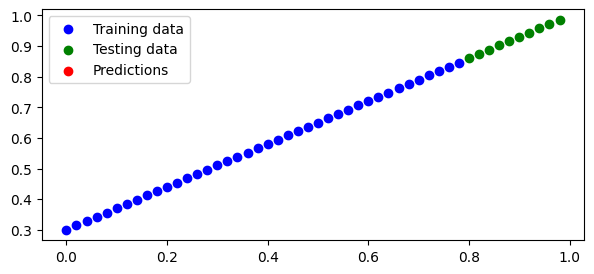

In [164]:
def plot_data(X=None, Y=None):
    plt.figure(figsize=(7, 3))
    plt.scatter(x=X_train, y=y_train, c='b', label='Training data')
    plt.scatter(x=X_test, y=y_test, c='g', label='Testing data')
    plt.scatter(x=X, y=Y, c='r', label='Predictions')
    plt.legend()
    plt.show()
plot_data()

# 1. Build Model
Our First Pytorch Model !!!

What our Model does:
- Start with random values (weight & bias)
- Look at the training data and adjust the random values to 
  better represent (or get closer to) ideal values (the weight & bias )

How does it do:
- Gradient Descent
- Backpropagation

In [165]:
# Create linear regression class
class LinearRegression(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

        self.weight = nn.Parameter(
            torch.randn(1, # -> Start with random values weight
                         requires_grad=True, # can this parameter updated via gradient descent??
                         dtype=torch.float # Pytorch love the datatype torch.float32
                        )
            )
        
        self.bias = nn.Parameter(
            torch.randn(1, # -> Start with random values bias
                         requires_grad=True, # can this parameter updated via gradient descent??
                         dtype=torch.float # Pytorch love the datatype torch.float32
                        )
            )

    # Forward method to define the computation in the model
    def forward(self, x: torch.Tensor) -> torch.Tensor: # -> 'x' is the input data
        return x * self.weight + self.bias # linear regression formula


### PyTorch Model Building Essentials

- **torch.nn**  
  Contains all of the building blocks for computational graphs  
  (a neural network can be considered a computational graph)

- **torch.nn.Parameter**  
  Defines which parameters the model should try to learn  
  (often PyTorch layers from `torch.nn` set these automatically)

- **torch.nn.Module**  
  The base class for all neural network modules  
  If you subclass it, you should overwrite `forward()`

- **torch.optim**  
  Contains PyTorch optimizers  
  These help with gradient descent

- **def forward()**  
  All `nn.Module` subclasses must implement `forward()`  
  This method defines what happens in the forward computation


## Checking the Contents of Our PyTorch Model

Now we've created a model, let's see what's inside.

We can check our model parameters (or what's inside our model) using  
`.parameters()`.

In [166]:
# Create a random seed
torch.manual_seed(42)

# Create an instance of the model
# (this is a subclass of nn.Module)
model_0 = LinearRegression()

# Check out the parameters
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [167]:
# List named parameter
model_0.state_dict()

OrderedDict([('weight', tensor([0.3367])), ('bias', tensor([0.1288]))])

### Making Predictions Using `torch.inference_mode()`

To check our model's predictive power, let's see how well it predicts  
`y_test` based on `x_test`.

When we pass data through our model, it runs the data through the  
`forward()` method.

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])


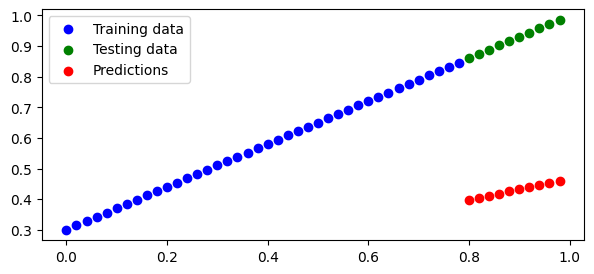

In [168]:
# Making Prediction with model
with torch.inference_mode():
    y_preds = model_0(X_test)

# You can also do something similar with torch.no_grad(), but torch.inference_mode() is a bit faster for inference
# because it completely disables gradient tracking (whereas torch.no_grad() just stops tracking gradients temporarily)
with torch.no_grad():
    y_preds = model_0(X_test)

print(y_preds)
plot_data(X=X_test, Y=y_preds)

## 3. Train the Model

The whole idea of training is for a model to move from some **unknown parameters**
(these may be random) to some **known parameters**.

In other words, training moves the model from a **poor representation of the data**
to a **better representation of the data**.

One way to measure how poor or how wrong our model's predictions, are is to use *loss function*

Things We Need to Train:

- **Loss function**  
  A function to measure how wrong your model's predictions are compared  
  to the ideal outputs. Lower is better.

- **Optimizer**  
  Takes into account the loss of a model and adjusts the model's  
  parameters (e.g. weights and bias).

And specifically for PyTorch, we need:

- A Training Loop
- A Testing Loop

In [169]:
# Setup a loss function
loss_fn = nn.L1Loss()

# Setup an optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.01)

### Building a Training Loop (and a Testing Loop) in PyTorch

A couple of things we need in a training loop:

0. **Loop through the data and do..**

1. **Forward pass**  
   Data moves through the model’s `forward()` function to make predictions  
   (also called *forward propagation*).

2. **Calculate the loss**  
   Compare forward pass predictions with ground-truth labels.

3. **Optimizer zero grad**  
   Reset gradients from the previous step.

4. **Loss backward**  
   Move backwards through the network to calculate gradients of each  
   model parameter with respect to the loss  
   (**backpropagation**).

5. **Optimizer step**  
   Use the optimizer to adjust the model’s parameters to improve the loss  
   (**gradient descent**).


Epoch: 0 | Train Loss: 0.3129 | Test Loss: 0.4811
OrderedDict({'weight': tensor([0.3406]), 'bias': tensor([0.1388])}) 

Epoch: 10 | Train Loss: 0.1977 | Test Loss: 0.3464
OrderedDict({'weight': tensor([0.3796]), 'bias': tensor([0.2388])}) 

Epoch: 20 | Train Loss: 0.0891 | Test Loss: 0.2173
OrderedDict({'weight': tensor([0.4184]), 'bias': tensor([0.3333])}) 

Epoch: 30 | Train Loss: 0.0531 | Test Loss: 0.1446
OrderedDict({'weight': tensor([0.4512]), 'bias': tensor([0.3768])}) 

Epoch: 40 | Train Loss: 0.0454 | Test Loss: 0.1136
OrderedDict({'weight': tensor([0.4748]), 'bias': tensor([0.3868])}) 

Epoch: 50 | Train Loss: 0.0417 | Test Loss: 0.0992
OrderedDict({'weight': tensor([0.4938]), 'bias': tensor([0.3843])}) 

Epoch: 60 | Train Loss: 0.0382 | Test Loss: 0.0889
OrderedDict({'weight': tensor([0.5116]), 'bias': tensor([0.3788])}) 

Epoch: 70 | Train Loss: 0.0348 | Test Loss: 0.0806
OrderedDict({'weight': tensor([0.5288]), 'bias': tensor([0.3718])}) 

Epoch: 80 | Train Loss: 0.0313 | 

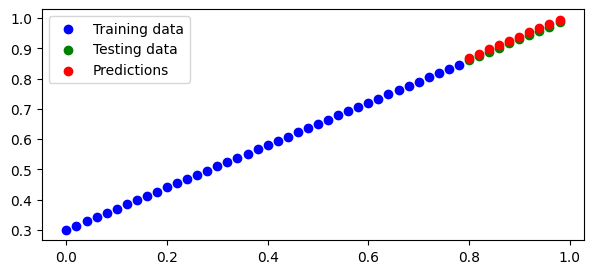

In [170]:
# An epoch is one loop through the data (this is a hyperparameter because we've set it ourselves)
epochs = 200

# Lists to track loss
train_loss_values = []
test_loss_values = []
epoch_count = []

# 0. Loop through the data
for epoch in range(epochs):

    # Set the model to training mode
    model_0.train() # train mode tells PyTorch to track gradients for parameters

    # 1. Forward Pass
    y_pred = model_0(X_train)

    # 2. Calculate Loss
    loss = loss_fn(y_pred, y_train)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Perform Backpropagation on the loss with repected to the parameter of the model
    loss.backward()

    # 5. Step the Optimizer (perform gradient descent)
    optimizer.step()


    # Set the model to evaluation mode / Testing
    model_0.eval() # eval mode turns off behaviors like dropout and batch norm updates
    with torch.inference_mode():

        # 1. Forward pass
        test_pred = model_0(X_test)

        # 2. Calculate the loss
        test_loss = loss_fn(test_pred, y_test)

    train_loss_values.append(loss.item())
    test_loss_values.append(test_loss.item())
    epoch_count.append(epoch)
    
    # Print out what's happening
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Train Loss: {loss:.4f} | Test Loss: {test_loss:.4f}")

        # print out the model state_dict
        print(model_0.state_dict(), '\n')

with torch.inference_mode():
    y_preds_1 = model_0(X_test)
plot_data(X=X_test, Y=y_preds_1)

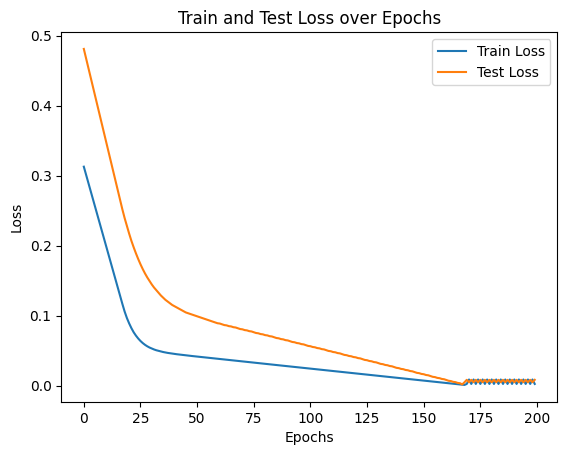

In [171]:
plt.plot(epoch_count, train_loss_values, label='Train Loss')
plt.plot(epoch_count, test_loss_values, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Test Loss over Epochs')
plt.legend()
plt.show()